 **Project 3: Classification of Sub-Reddits with NLP**
 ***

# Introduction

In this section, I aim to train a few models to perform predictions on this binary classification problem. The process is as follows:

**Lemmatization $\rightarrow$ Vectorization $\rightarrow$ Modelling (train dataset) $\rightarrow$ Predicting**

It is good practice to tokenize or lemmatize before using sklearn's vectorization tools (`Count/TF-IDF Vectorizer`) otherwise a naive splitting by spaces will be applied sklearn. I have used nltk's `WordNetLemmatizer` for this project.

Very broadly, I have trained several models (Logistic Regression, Random Forest and Multinomial Naive Bayes) and tuned the parameters with `GridSearchCV`. The best model is **Count Vectorization + Multinomial Naive Bayes (with lemmatization)**. I will further explain my methodology and results in the sections below.

## Import Libraries and Load Datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import requests

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, plot_roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.set_option('display.max_colwidth', 0)

%matplotlib inline

In [3]:
problems = pd.read_csv('../datasets/clean_problems.csv')

In [4]:
success = pd.read_csv('../datasets/clean_success.csv')

In [5]:
problems.shape

(1241, 7)

In [6]:
success.shape

(1451, 7)

## Functions

In [7]:
def results(model, X_test, y_test):
    '''Function to print model results in a dataframe'''
    
    best_score = np.round(model.best_score_,5)
    
    accuracy = np.round(accuracy_score(y_test, model.predict(X_test)),5)
    precision = np.round(precision_score(y_test, model.predict(X_test)),5)
    recall = np.round(recall_score(y_test, model.predict(X_test)),5)
    
    f1 = np.round(f1_score(y_test, model.predict(X_test)),5)
    
    best_params = model.best_params_
    
    summary = {'Best Score': best_score,
               'Test Score (accuracy)': accuracy,
               'Precision': precision,
               'Recall': recall,
               'F1': f1,
              'Best Params': best_params}
    
    summary_df = pd.DataFrame.from_dict(summary, orient='Index', columns=[str(model.estimator.steps[0][0])+ ' x ' + str(model.estimator.steps[1][0])])
    return summary_df

## Define Stop Words

These are the same 326 stop words as part 1.

In [8]:
new_stop_words = ['success', 'problem', 'successes', 'problems', 'british', 've', 'wa', 'ha']
total_stop_words = text.ENGLISH_STOP_WORDS.union(new_stop_words)

In [68]:
len(total_stop_words )

326

# Pre-Processing

## Lemmatization

Lemmatization will be applied to all posts in the sub-reddit. In this case, all the posts in the two sub-reddits will be known as the **corpus**. I wrote a function `lemmatize` to perform the lemmatization per post. This is then applied to the entire corpus using a `for` loop. 

In [10]:
def lemmatize(content):
    '''Function to lemmatize a document'''
    lemmatizer = WordNetLemmatizer()
    
    words = content.lower().split()
    lem_words = [lemmatizer.lemmatize(i) for i in words]
    
    return(' '.join(lem_words))

In [69]:
#Lemmatize all the posts in 'Problems' and 'Success'

lem_problems_posts = []
lem_success_posts = []

for problems_post in problems['content']:
    lem_problems_posts.append(lemmatize(problems_post))
    
for success_post in success['content']:
    lem_success_posts.append(lemmatize(success_post))

problems['content_lem'] = pd.DataFrame(lem_problems_posts)
success['content_lem'] = pd.DataFrame(lem_success_posts)

## Label and Concate Datasets

Encoded British Problems subreddit with '1' and British Success subreddit with '0'

In [12]:
problems['label'] = 1
success['label'] = 0

Combined both subreddits into one dataset titled '**problems_success**'.

In [13]:
problems_success = pd.concat([problems, success], ignore_index=True)

In [70]:
problems_success.shape

(2692, 9)

# Modelling

I would broadly categorise my modelling process into 3 parts:
- **Part 1**: Lemmatization with CountVectorizer x Logistic Regression / Random Forest / Multinomial Naive Bayes
- **Part 2**: Lemmatization with TF-IDF Vectorizer x Logistic Regression / Random Forest / Multinomial Naive Bayes
- **Part 3**: CountVectorizer/TF-IDF Vectorizer x Random Forest / Multinomial Naive Bayes

The best model I found is the **Lemmatization with CountVectorizer x Multinomial Naive Bayes** as it has the best accuracy score (0.77) across all models that I tested. Similarly, it has the best F1 score and fairly balanced precision and recall scores.

The difference in Part 1 and Part 2 is the vectorization tool used (CountVectorizer vs TF-IDF Vectorizer). Compared to CountVectorizer, TF-IDF will increase weights on less common words (since they potentially have better predictive value). After completing Part 1 and 2, I removed the lemmatization step to see if it improves my model (it did not).

In all 3 parts of the modelling section, I have used GridSearchCV to tune the hyperparameters of the model I am using. In general, these are the parameters I used in my models (with specific tuning based on each model):
    
    'cvec/tvec__max_features': [2000, 3000, 4000],
    'cvec/tvec__min_df': [2, 3],
    'cvec/tvec__max_df': [0.9, 0.95],
    'cvec/tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'cvec/tvec__stop_words': [total_stop_words],

More details will be explained in the following sections.

## Define and Split Train/Test 

In [15]:
X = problems_success['content_lem']
y = problems_success['label']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

## Baseline Accruracy

Since the number of posts in both datasets are fairly close, we have a baseline accuracy of **46%** for 1 ('problems'). We compare our models against the baseline accuracy to see how well it performs.

In [18]:
y.value_counts(normalize=True)

0    0.539004
1    0.460996
Name: label, dtype: float64

## Part 1: Lemmatization & Count Vectorizer

### Count Vectorizer x Logistic Regression

In [19]:
%%time

pipe_cvlogreg = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression(max_iter=10000))
])

pipe_cvlogreg_params = {
    'cvec__max_features': [2000, 3000, 4000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'cvec__stop_words': [total_stop_words],
    'logreg__C': [0.1, 1, 10]
    
}

gs_cvlogreg = GridSearchCV(pipe_cvlogreg, 
                  param_grid=pipe_cvlogreg_params, 
                  cv=5,
                 n_jobs=-1)

gs_cvlogreg.fit(X_train, y_train)

CPU times: user 2.14 s, sys: 407 ms, total: 2.55 s
Wall time: 27.2 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logreg',
                                        LogisticRegression(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'cvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                      

In [20]:
results(gs_cvlogreg, X_test, y_test)

,cvec x logreg
Best Score,0.72463
Test Score (accuracy),0.737
Precision,0.72696
Recall,0.6871
F1,0.70647
Best Params,"{'cvec__max_df': 0.9, 'cvec__max_features': 4000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': ('myself', 'all', 'both', 'take', 'themselves', 'hundred', 'each', 'further', 'first', 'someone', 'hasnt', 'when', 'may', 'upon', 'by', 'system', 'enough', 'too', 'they', 'therefore', 'across', 'per', 'to', 'whence', 'within', 'twenty', 'part', 'will', 'whereupon', 'everything', 'name', 'bill', 'afterwards', 'who', 'mine', 'nothing', 'give', 'some', 'thereby', 'can', 'therein', 'thin', 'something', 'get', 'it', 'beforehand', 'etc', 'back', 'always', 'amongst', 'top', 'nowhere', 'thus', 'rather', 'until', 'anyhow', 'above', 'but', 'or', 'on', 'me', 'last', 'successes', 'i', 'bottom', 'problem', 'very', 'twelve', 'still', 'toward', 'ten', 'neither', 'mill', 'them', 'wherein', 'around', 'thereupon', 've', 'thick', 'a', 'serious', 'detail', 'least', 'anyone', 'over', 'put', 'anything', 'cant', 'else', 'had', 'throughout', 'he', 'beyond', 'us', 'were', 'how', 'under', 'eg', 'few', 'interest', ...), 'logreg__C': 1}"


### Count Vectorizer x Random Forest 

For Random Forest models, I have expanded the number of features to 5000 and 7000 since multiple hyperparameter tuning have turned up with high max_features. 

In [21]:
%%time

pipe_cvrf = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

pipe_cvrf_params = {
    'cvec__max_features': [2000, 3000, 4000, 5000, 7000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'cvec__stop_words': [total_stop_words],
    'rf__n_estimators': [100, 150],
    'rf__min_samples_leaf': [1,2,3]
}


gs_cvrf = GridSearchCV(pipe_cvrf, 
                  param_grid=pipe_cvrf_params,
                  cv=5,
                  n_jobs=-1)

gs_cvrf.fit(X_train, y_train)

CPU times: user 6.98 s, sys: 453 ms, total: 7.44 s
Wall time: 4min 38s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000, 7000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'cvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                         'also', 'although',
                   

In [22]:
results(gs_cvrf, X_test, y_test)

,cvec x rf
Best Score,0.72214
Test Score (accuracy),0.75632
Precision,0.76449
Recall,0.68065
F1,0.72014
Best Params,"{'cvec__max_df': 0.9, 'cvec__max_features': 7000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': ('myself', 'all', 'both', 'take', 'themselves', 'hundred', 'each', 'further', 'first', 'someone', 'hasnt', 'when', 'may', 'upon', 'by', 'system', 'enough', 'too', 'they', 'therefore', 'across', 'per', 'to', 'whence', 'within', 'twenty', 'part', 'will', 'whereupon', 'everything', 'name', 'bill', 'afterwards', 'who', 'mine', 'nothing', 'give', 'some', 'thereby', 'can', 'therein', 'thin', 'something', 'get', 'it', 'beforehand', 'etc', 'back', 'always', 'amongst', 'top', 'nowhere', 'thus', 'rather', 'until', 'anyhow', 'above', 'but', 'or', 'on', 'me', 'last', 'successes', 'i', 'bottom', 'problem', 'very', 'twelve', 'still', 'toward', 'ten', 'neither', 'mill', 'them', 'wherein', 'around', 'thereupon', 've', 'thick', 'a', 'serious', 'detail', 'least', 'anyone', 'over', 'put', 'anything', 'cant', 'else', 'had', 'throughout', 'he', 'beyond', 'us', 'were', 'how', 'under', 'eg', 'few', 'interest', ...), 'rf__min_samples_leaf': 3, 'rf__n_estimators': 150}"


### Count Vectorizer x Mulitnomial Naive Bayes

In [23]:
%%time

pipe_cvnb = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

pipe_cvnb_params = {
    'cvec__max_features': [2000, 3000, 4000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'cvec__stop_words': [total_stop_words],
    'nb__alpha': [1,2,3]
}


gs_cvnb = GridSearchCV(pipe_cvnb, 
                  param_grid=pipe_cvnb_params,
                  cv=5,
                  n_jobs=-1)

gs_cvnb.fit(X_train, y_train)

CPU times: user 1.15 s, sys: 90.1 ms, total: 1.24 s
Wall time: 20.3 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'cvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                         'also', 'although',
                                        

In [25]:
results(gs_cvnb, X_test, y_test)

,cvec x nb
Best Score,0.74096
Test Score (accuracy),0.77117
Precision,0.75161
Recall,0.75161
F1,0.75161
Best Params,"{'cvec__max_df': 0.9, 'cvec__max_features': 3000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': ('myself', 'all', 'both', 'take', 'themselves', 'hundred', 'each', 'further', 'first', 'someone', 'hasnt', 'when', 'may', 'upon', 'by', 'system', 'enough', 'too', 'they', 'therefore', 'across', 'per', 'to', 'whence', 'within', 'twenty', 'part', 'will', 'whereupon', 'everything', 'name', 'bill', 'afterwards', 'who', 'mine', 'nothing', 'give', 'some', 'thereby', 'can', 'therein', 'thin', 'something', 'get', 'it', 'beforehand', 'etc', 'back', 'always', 'amongst', 'top', 'nowhere', 'thus', 'rather', 'until', 'anyhow', 'above', 'but', 'or', 'on', 'me', 'last', 'successes', 'i', 'bottom', 'problem', 'very', 'twelve', 'still', 'toward', 'ten', 'neither', 'mill', 'them', 'wherein', 'around', 'thereupon', 've', 'thick', 'a', 'serious', 'detail', 'least', 'anyone', 'over', 'put', 'anything', 'cant', 'else', 'had', 'throughout', 'he', 'beyond', 'us', 'were', 'how', 'under', 'eg', 'few', 'interest', ...), 'nb__alpha': 1}"


## Part 2: Lemmatization & TF-IDF

### TF-IDF Vectorizer x Logistic Regression

In [29]:
%%time

pipe_tvlogreg = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logreg', LogisticRegression(max_iter=10000))
])

pipe_tvlogreg_params = {
    'tvec__max_features': [2000, 3000, 4000],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [0.9, 0.95],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'tvec__stop_words': [total_stop_words],
    'logreg__C': [0.1, 1, 10]
}

gs_tvlogreg = GridSearchCV(pipe_tvlogreg, 
                  param_grid=pipe_tvlogreg_params, 
                  cv=5,
                 n_jobs=-1)

gs_tvlogreg.fit(X_train, y_train)

CPU times: user 1.75 s, sys: 118 ms, total: 1.86 s
Wall time: 30.5 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logreg',
                                        LogisticRegression(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'logreg__C': [0.1, 1, 10], 'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'tvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                     

In [30]:
results(gs_tvlogreg, X_test, y_test)

,tvec x logreg
Best Score,0.73354
Test Score (accuracy),0.75632
Precision,0.76259
Recall,0.68387
F1,0.72109
Best Params,"{'logreg__C': 1, 'tvec__max_df': 0.9, 'tvec__max_features': 4000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': ('myself', 'all', 'both', 'take', 'themselves', 'hundred', 'each', 'further', 'first', 'someone', 'hasnt', 'when', 'may', 'upon', 'by', 'system', 'enough', 'too', 'they', 'therefore', 'across', 'per', 'to', 'whence', 'within', 'twenty', 'part', 'will', 'whereupon', 'everything', 'name', 'bill', 'afterwards', 'who', 'mine', 'nothing', 'give', 'some', 'thereby', 'can', 'therein', 'thin', 'something', 'get', 'it', 'beforehand', 'etc', 'back', 'always', 'amongst', 'top', 'nowhere', 'thus', 'rather', 'until', 'anyhow', 'above', 'but', 'or', 'on', 'me', 'last', 'successes', 'i', 'bottom', 'problem', 'very', 'twelve', 'still', 'toward', 'ten', 'neither', 'mill', 'them', 'wherein', 'around', 'thereupon', 've', 'thick', 'a', 'serious', 'detail', 'least', 'anyone', 'over', 'put', 'anything', 'cant', 'else', 'had', 'throughout', 'he', 'beyond', 'us', 'were', 'how', 'under', 'eg', 'few', 'interest', ...)}"


### TF-IDF Vectorizer x Random Forest

In [31]:
%%time

pipe_tvrf = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

pipe_tvrf_params = {
    'tvec__max_features': [2000, 3000, 4000, 5000, 7000],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'tvec__stop_words': [total_stop_words],
    'rf__n_estimators': [100, 150],
    'rf__min_samples_leaf': [1,2,3]
}


gs_tvrf = GridSearchCV(pipe_tvrf, 
                  param_grid=pipe_tvrf_params,
                  cv=5,
                  n_jobs=-1)

gs_tvrf.fit(X_train, y_train)

CPU times: user 7.37 s, sys: 464 ms, total: 7.84 s
Wall time: 4min 55s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__min_samples_leaf': [1, 2, 3],
                         'rf__n_estimators': [100, 150],
                         'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [2000, 3000, 4000, 5000, 7000],
                         'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'tvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                        

In [32]:
results(gs_tvrf, X_test, y_test)

,tvec x rf
Best Score,0.71769
Test Score (accuracy),0.75037
Precision,0.7415
Recall,0.70323
F1,0.72185
Best Params,"{'rf__min_samples_leaf': 3, 'rf__n_estimators': 150, 'tvec__max_df': 0.95, 'tvec__max_features': 7000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': ('myself', 'all', 'both', 'take', 'themselves', 'hundred', 'each', 'further', 'first', 'someone', 'hasnt', 'when', 'may', 'upon', 'by', 'system', 'enough', 'too', 'they', 'therefore', 'across', 'per', 'to', 'whence', 'within', 'twenty', 'part', 'will', 'whereupon', 'everything', 'name', 'bill', 'afterwards', 'who', 'mine', 'nothing', 'give', 'some', 'thereby', 'can', 'therein', 'thin', 'something', 'get', 'it', 'beforehand', 'etc', 'back', 'always', 'amongst', 'top', 'nowhere', 'thus', 'rather', 'until', 'anyhow', 'above', 'but', 'or', 'on', 'me', 'last', 'successes', 'i', 'bottom', 'problem', 'very', 'twelve', 'still', 'toward', 'ten', 'neither', 'mill', 'them', 'wherein', 'around', 'thereupon', 've', 'thick', 'a', 'serious', 'detail', 'least', 'anyone', 'over', 'put', 'anything', 'cant', 'else', 'had', 'throughout', 'he', 'beyond', 'us', 'were', 'how', 'under', 'eg', 'few', 'interest', ...)}"


### TF-IDF Vectorizer x Mulitnomial Naive Bayes

In [33]:
%%time

pipe_tvnb = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_tvnb_params = {
    'tvec__max_features': [2000, 3000, 4000, 5000],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'tvec__stop_words': [total_stop_words],
    'nb__alpha': [1,2,3]
}


gs_tvnb = GridSearchCV(pipe_tvnb, 
                  param_grid=pipe_tvnb_params,
                  cv=5,
                  n_jobs=-1)

gs_tvnb.fit(X_train, y_train)

CPU times: user 1.71 s, sys: 119 ms, total: 1.83 s
Wall time: 27.5 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'nb__alpha': [1, 2, 3], 'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'tvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                         'also', 'although',
          

In [34]:
results(gs_tvnb, X_test, y_test)

,tvec x nb
Best Score,0.73106
Test Score (accuracy),0.75186
Precision,0.77395
Recall,0.65161
F1,0.70753
Best Params,"{'nb__alpha': 1, 'tvec__max_df': 0.9, 'tvec__max_features': 2000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': ('myself', 'all', 'both', 'take', 'themselves', 'hundred', 'each', 'further', 'first', 'someone', 'hasnt', 'when', 'may', 'upon', 'by', 'system', 'enough', 'too', 'they', 'therefore', 'across', 'per', 'to', 'whence', 'within', 'twenty', 'part', 'will', 'whereupon', 'everything', 'name', 'bill', 'afterwards', 'who', 'mine', 'nothing', 'give', 'some', 'thereby', 'can', 'therein', 'thin', 'something', 'get', 'it', 'beforehand', 'etc', 'back', 'always', 'amongst', 'top', 'nowhere', 'thus', 'rather', 'until', 'anyhow', 'above', 'but', 'or', 'on', 'me', 'last', 'successes', 'i', 'bottom', 'problem', 'very', 'twelve', 'still', 'toward', 'ten', 'neither', 'mill', 'them', 'wherein', 'around', 'thereupon', 've', 'thick', 'a', 'serious', 'detail', 'least', 'anyone', 'over', 'put', 'anything', 'cant', 'else', 'had', 'throughout', 'he', 'beyond', 'us', 'were', 'how', 'under', 'eg', 'few', 'interest', ...)}"


## Summary

With lemmatization, the CountVectorizer x Multinomial Naive Bayes model performed the best (highest accuracy score at 0.77). It also has the highest F1 score at 0.75 (good balance of precision and recall). 

A point to note: all models are not too dissimilar in terms of accuracy score - they range from 0.73 to 0.77

In [35]:
overall_df = pd.concat([results(gs_cvlogreg, X_test, y_test), results(gs_cvrf, X_test, y_test), results(gs_cvnb, X_test, y_test), results(gs_tvlogreg, X_test, y_test), results(gs_tvrf, X_test, y_test), results(gs_tvnb, X_test, y_test)],axis=1).T

In [36]:
overall_df.sort_values(ascending=False, by='Test Score (accuracy)').drop(columns='Best Params')

,Best Score,Test Score (accuracy),Precision,Recall,F1
cvec x nb,0.74096,0.77117,0.75161,0.75161,0.75161
cvec x rf,0.72214,0.75632,0.76449,0.68065,0.72014
tvec x logreg,0.73354,0.75632,0.76259,0.68387,0.72109
tvec x nb,0.73106,0.75186,0.77395,0.65161,0.70753
tvec x rf,0.71769,0.75037,0.7415,0.70323,0.72185
cvec x logreg,0.72463,0.737,0.72696,0.6871,0.70647


## Part 3: Without Lemmatization

The rationale for removing lemmatization in the steps below is to see if we could make our modelling 'simpler' by avoiding excessive tokenization of the corpus. I only performed these on the Multinomial Naive Bayes and Random Forest models as they have the highest accuracy scores in Part 1 and Part 2.

In [110]:
X_non_lemma = problems_success['content']
y_non_lemma = problems_success['label']

In [111]:
X_nl_train, X_nl_test, y_nl_train, y_nl_test = train_test_split(X_non_lemma, y_non_lemma, stratify=y, random_state=42)

### Count Vectorizer x Multinomial Naive Bayes

In [112]:
%%time

pipe_nl_cvnb = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

pipe_nl_cvnb_params = {
    'cvec__max_features': [2000, 3000, 4000, 5000,7500],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'cvec__stop_words': [total_stop_words],    
    'nb__alpha': [1,2,3]
}

gs_nl_cvnb = GridSearchCV(pipe_nl_cvnb, 
                  param_grid=pipe_nl_cvnb_params, 
                  cv=5,
                 n_jobs=-1)

gs_nl_cvnb.fit(X_nl_train, y_nl_train)

CPU times: user 2.78 s, sys: 279 ms, total: 3.06 s
Wall time: 35 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000, 7500],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'cvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                         'also', 'although',
                            

In [113]:
results(gs_nl_cvnb, X_nl_test, y_nl_test)

,cvec x nb
Best Score,0.73799
Test Score (accuracy),0.76077
Precision,0.74587
Recall,0.72903
F1,0.73736
Best Params,"{'cvec__max_df': 0.9, 'cvec__max_features': 2000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': ('myself', 'all', 'both', 'take', 'themselves', 'hundred', 'each', 'further', 'first', 'someone', 'hasnt', 'when', 'may', 'upon', 'by', 'system', 'enough', 'too', 'they', 'therefore', 'across', 'per', 'to', 'whence', 'within', 'twenty', 'part', 'will', 'whereupon', 'everything', 'name', 'bill', 'afterwards', 'who', 'mine', 'nothing', 'give', 'some', 'thereby', 'can', 'therein', 'thin', 'something', 'get', 'it', 'beforehand', 'etc', 'back', 'always', 'amongst', 'top', 'nowhere', 'thus', 'rather', 'until', 'anyhow', 'above', 'but', 'or', 'on', 'me', 'last', 'successes', 'i', 'bottom', 'problem', 'very', 'twelve', 'still', 'toward', 'ten', 'neither', 'mill', 'them', 'wherein', 'around', 'thereupon', 've', 'thick', 'a', 'serious', 'detail', 'least', 'anyone', 'over', 'put', 'anything', 'cant', 'else', 'had', 'throughout', 'he', 'beyond', 'us', 'were', 'how', 'under', 'eg', 'few', 'interest', ...), 'nb__alpha': 2}"


### TF-IDF Vectorizer x Multinomial Naive Bayes

In [114]:
%%time

pipe_nl_tvnb = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_nl_tvnb_params = {
    'tvec__max_features': [2000, 3000, 4000, 5000,7500],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [0.9, 0.95],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'tvec__stop_words': [total_stop_words],
    'nb__alpha': [1,2,3]
}

gs_nl_tvnb = GridSearchCV(pipe_nl_tvnb, 
                  param_grid=pipe_nl_tvnb_params, 
                  cv=5,
                 n_jobs=-1)

gs_nl_tvnb.fit(X_nl_train, y_nl_train)

CPU times: user 1.96 s, sys: 119 ms, total: 2.08 s
Wall time: 33.9 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'nb__alpha': [1, 2, 3], 'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [2000, 3000, 4000, 5000, 7500],
                         'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'tvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                         'also', 'although',
    

In [115]:
results(gs_nl_tvnb, X_nl_test, y_nl_test)

,tvec x nb
Best Score,0.72562
Test Score (accuracy),0.75929
Precision,0.79839
Recall,0.63871
F1,0.70968
Best Params,"{'nb__alpha': 1, 'tvec__max_df': 0.9, 'tvec__max_features': 3000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': ('myself', 'all', 'both', 'take', 'themselves', 'hundred', 'each', 'further', 'first', 'someone', 'hasnt', 'when', 'may', 'upon', 'by', 'system', 'enough', 'too', 'they', 'therefore', 'across', 'per', 'to', 'whence', 'within', 'twenty', 'part', 'will', 'whereupon', 'everything', 'name', 'bill', 'afterwards', 'who', 'mine', 'nothing', 'give', 'some', 'thereby', 'can', 'therein', 'thin', 'something', 'get', 'it', 'beforehand', 'etc', 'back', 'always', 'amongst', 'top', 'nowhere', 'thus', 'rather', 'until', 'anyhow', 'above', 'but', 'or', 'on', 'me', 'last', 'successes', 'i', 'bottom', 'problem', 'very', 'twelve', 'still', 'toward', 'ten', 'neither', 'mill', 'them', 'wherein', 'around', 'thereupon', 've', 'thick', 'a', 'serious', 'detail', 'least', 'anyone', 'over', 'put', 'anything', 'cant', 'else', 'had', 'throughout', 'he', 'beyond', 'us', 'were', 'how', 'under', 'eg', 'few', 'interest', ...)}"


### Count Vectorizer x Random Forest

In [116]:
%%time

pipe_nl_cvrf = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

pipe_nl_cvrf_params = {
    'cvec__max_features': [2000, 3000, 4000, 5000, 7000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'cvec__stop_words': [total_stop_words],
    'rf__n_estimators': [100, 150],
    'rf__min_samples_leaf': [1,2,3]
}

gs_nl_cvrf = GridSearchCV(pipe_nl_cvrf, 
                  param_grid=pipe_nl_cvrf_params, 
                  cv=5,
                 n_jobs=-1)

gs_nl_cvrf.fit(X_nl_train, y_nl_train)

CPU times: user 6.8 s, sys: 461 ms, total: 7.26 s
Wall time: 4min 34s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000, 7000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'cvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                         'also', 'although',
                   

In [117]:
results(gs_nl_cvrf, X_nl_test, y_nl_test)

,cvec x rf
Best Score,0.72413
Test Score (accuracy),0.74591
Precision,0.76834
Recall,0.64194
F1,0.69947
Best Params,"{'cvec__max_df': 0.9, 'cvec__max_features': 7000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': ('myself', 'all', 'both', 'take', 'themselves', 'hundred', 'each', 'further', 'first', 'someone', 'hasnt', 'when', 'may', 'upon', 'by', 'system', 'enough', 'too', 'they', 'therefore', 'across', 'per', 'to', 'whence', 'within', 'twenty', 'part', 'will', 'whereupon', 'everything', 'name', 'bill', 'afterwards', 'who', 'mine', 'nothing', 'give', 'some', 'thereby', 'can', 'therein', 'thin', 'something', 'get', 'it', 'beforehand', 'etc', 'back', 'always', 'amongst', 'top', 'nowhere', 'thus', 'rather', 'until', 'anyhow', 'above', 'but', 'or', 'on', 'me', 'last', 'successes', 'i', 'bottom', 'problem', 'very', 'twelve', 'still', 'toward', 'ten', 'neither', 'mill', 'them', 'wherein', 'around', 'thereupon', 've', 'thick', 'a', 'serious', 'detail', 'least', 'anyone', 'over', 'put', 'anything', 'cant', 'else', 'had', 'throughout', 'he', 'beyond', 'us', 'were', 'how', 'under', 'eg', 'few', 'interest', ...), 'rf__min_samples_leaf': 3, 'rf__n_estimators': 100}"


### TF-IDF Vectorizer x Random Forest

In [118]:
%%time

pipe_nl_tvrf = Pipeline([
    ('tvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

pipe_nl_tvrf_params = {
    'tvec__max_features': [2000, 3000, 4000, 5000, 7000],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [0.9, 0.95],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'tvec__stop_words': [total_stop_words],   
    'rf__n_estimators': [100, 150],
    'rf__min_samples_leaf': [1,2,3]
}

gs_nl_tvrf = GridSearchCV(pipe_nl_tvrf, 
                  param_grid=pipe_nl_tvrf_params, 
                  cv=5,
                 n_jobs=-1)

gs_nl_tvrf.fit(X_nl_train, y_nl_train)

CPU times: user 7.31 s, sys: 992 ms, total: 8.3 s
Wall time: 4min 58s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__min_samples_leaf': [1, 2, 3],
                         'rf__n_estimators': [100, 150],
                         'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [2000, 3000, 4000, 5000, 7000],
                         'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'tvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                        

In [119]:
results(gs_nl_tvrf, X_nl_test, y_nl_test)

,tvec x rf
Best Score,0.72562
Test Score (accuracy),0.75186
Precision,0.78039
Recall,0.64194
F1,0.70442
Best Params,"{'rf__min_samples_leaf': 3, 'rf__n_estimators': 100, 'tvec__max_df': 0.95, 'tvec__max_features': 4000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': ('myself', 'all', 'both', 'take', 'themselves', 'hundred', 'each', 'further', 'first', 'someone', 'hasnt', 'when', 'may', 'upon', 'by', 'system', 'enough', 'too', 'they', 'therefore', 'across', 'per', 'to', 'whence', 'within', 'twenty', 'part', 'will', 'whereupon', 'everything', 'name', 'bill', 'afterwards', 'who', 'mine', 'nothing', 'give', 'some', 'thereby', 'can', 'therein', 'thin', 'something', 'get', 'it', 'beforehand', 'etc', 'back', 'always', 'amongst', 'top', 'nowhere', 'thus', 'rather', 'until', 'anyhow', 'above', 'but', 'or', 'on', 'me', 'last', 'successes', 'i', 'bottom', 'problem', 'very', 'twelve', 'still', 'toward', 'ten', 'neither', 'mill', 'them', 'wherein', 'around', 'thereupon', 've', 'thick', 'a', 'serious', 'detail', 'least', 'anyone', 'over', 'put', 'anything', 'cant', 'else', 'had', 'throughout', 'he', 'beyond', 'us', 'were', 'how', 'under', 'eg', 'few', 'interest', ...)}"


## Summary

By removing the lemmatization step, our models did not perform better. They are fairly similar for the Random Forest models. With this in mind, a model with lemmatization performed in the pre-processing step will be chosen as the final model to deploy.

In [120]:
overall_nl_df = pd.concat([results(gs_nl_tvrf, X_nl_test, y_nl_test), results(gs_nl_cvrf, X_nl_test, y_nl_test), results(gs_nl_cvnb, X_nl_test, y_nl_test), results(gs_nl_tvnb, X_nl_test, y_nl_test)],axis=1).T

In [121]:
overall_nl_df.drop(columns='Best Params').sort_values(ascending=False, by='Test Score (accuracy)')

,Best Score,Test Score (accuracy),Precision,Recall,F1
cvec x nb,0.73799,0.76077,0.74587,0.72903,0.73736
tvec x nb,0.72562,0.75929,0.79839,0.63871,0.70968
tvec x rf,0.72562,0.75186,0.78039,0.64194,0.70442
cvec x rf,0.72413,0.74591,0.76834,0.64194,0.69947


## Final Model : Lemmatized & Count Vectorizer x Multinomial Naive Bayes

As mentioned previously, I have chosen the **Lemmatized & Count Vectorizer x Multinomial Naive Bayes** model. From the previous section, the model has obtained an accuracy score of **0.77**. 

I suspect that I can further improve the model by including punction marks such as '!'. CountVectorizer automatically drops punctuations but I suspect that they might be useful in classifcation here because. For example, '!' is found in 454 entries of 'British Success' versus 186 entries of 'British Problems' (not surprising since we often use '!' with something positive). It would be useful to find out if they play a part in improving the model.

By doing so, I have improved the accuracy score slightly to **0.79**. The F1 score has also improved slightly (0.775)

In [122]:
%%time

pipe_cvnb = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

pipe_cvnb_params = {
    'cvec__max_features': [2000, 3000, 4000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'cvec__stop_words': [total_stop_words],
    'cvec__token_pattern': [r"(?u)\b\w\w+\b|!|\?|\"|\'"],
    'nb__alpha': [1,2,3]
}


gs_cvnb = GridSearchCV(pipe_cvnb, 
                  param_grid=pipe_cvnb_params,
                  cv=5,
                  n_jobs=-1)

gs_cvnb.fit(X_train, y_train)

CPU times: user 1.2 s, sys: 96.7 ms, total: 1.3 s
Wall time: 22.8 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'cvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                         'also', 'although',
                                        

In [123]:
gs_cvnb.score(X_test, y_test)

0.7919762258543833

In [142]:
results(gs_cvnb, X_test, y_test)

,cvec x nb
Best Score,0.74939
Test Score (accuracy),0.79198
Precision,0.7707
Recall,0.78065
F1,0.77564
Best Params,"{'cvec__max_df': 0.9, 'cvec__max_features': 4000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': ('myself', 'all', 'both', 'take', 'themselves', 'hundred', 'each', 'further', 'first', 'someone', 'hasnt', 'when', 'may', 'upon', 'by', 'system', 'enough', 'too', 'they', 'therefore', 'across', 'per', 'to', 'whence', 'within', 'twenty', 'part', 'will', 'whereupon', 'everything', 'name', 'bill', 'afterwards', 'who', 'mine', 'nothing', 'give', 'some', 'thereby', 'can', 'therein', 'thin', 'something', 'get', 'it', 'beforehand', 'etc', 'back', 'always', 'amongst', 'top', 'nowhere', 'thus', 'rather', 'until', 'anyhow', 'above', 'but', 'or', 'on', 'me', 'last', 'successes', 'i', 'bottom', 'problem', 'very', 'twelve', 'still', 'toward', 'ten', 'neither', 'mill', 'them', 'wherein', 'around', 'thereupon', 've', 'thick', 'a', 'serious', 'detail', 'least', 'anyone', 'over', 'put', 'anything', 'cant', 'else', 'had', 'throughout', 'he', 'beyond', 'us', 'were', 'how', 'under', 'eg', 'few', 'interest', ...), 'cvec__token_pattern': '(?u)\b\w\w+\b|!|\?|\""|\'', 'nb__alpha': 2}"


### Feature Analysis

To evaluate the model, I start with understanding the features that help explain the difference between the two classes (i.e. the two sub-reddits). I used log probability difference as the metric here as it identifies words that are more frequent in one sub-reddit relative to the other. The results of each sub-reddit are reflected in the barplots below.

**Key Observations**
- Crane is the most 'different' word that explains why a post will be classified in 'British Problems' than in 'British Succes'. 
    - Crane probably means 'crane flies' a.k.a 'daddy long legs' which was one of the most common trigrams in our EDA section. These trigrams did not appear here because the optimised model I used deployed unigram as the ideal vectorization parameter.
    - The reason why crane flies/daddy long legs appeared so frequently is probably due to the exceptionally wet summer that UK just had and people are complaining about these flies! [Source: Is UK seeing a record daddy long legs invasion? (Guardian)](https://www.theguardian.com/environment/2021/sep/22/is-the-uk-really-seeing-a-record-daddy-long-legs-invasion)
- Words with negative connotation also top the list for 'British Problems': 'unable', 'worse', 'arse', 'fucking', 'upset'
- For 'British Success', words associated with covid topped the list: 'vaccine', 'mask', 'nhs'. This is likely due to the full unwound of covid restrictions in the UK in July. 
- Words associated with 'overcoming' a problem/challenge have also appeared in the 'British Success' list: 'finally', 'managed'. 
- The words 'wife' and 'son' in 'British Success' make a surprising entrance - would be interesting to find out why!

In [125]:
log_diff = list(zip(words_cvnb, log_prob_diff_cvnb))
log_diff_df = pd.DataFrame(log_diff, columns=['Word','Log Diff'])

In [126]:
words_cvnb = gs_cvnb.best_estimator_.steps[0][1].get_feature_names()
log_prob_0_cvnb = gs_cvnb.best_estimator_.steps[1][1].feature_log_prob_[0]
log_prob_1_cvnb = gs_cvnb.best_estimator_.steps[1][1].feature_log_prob_[1]
log_prob_diff_cvnb = log_prob_1_cvnb - log_prob_0_cvnb 

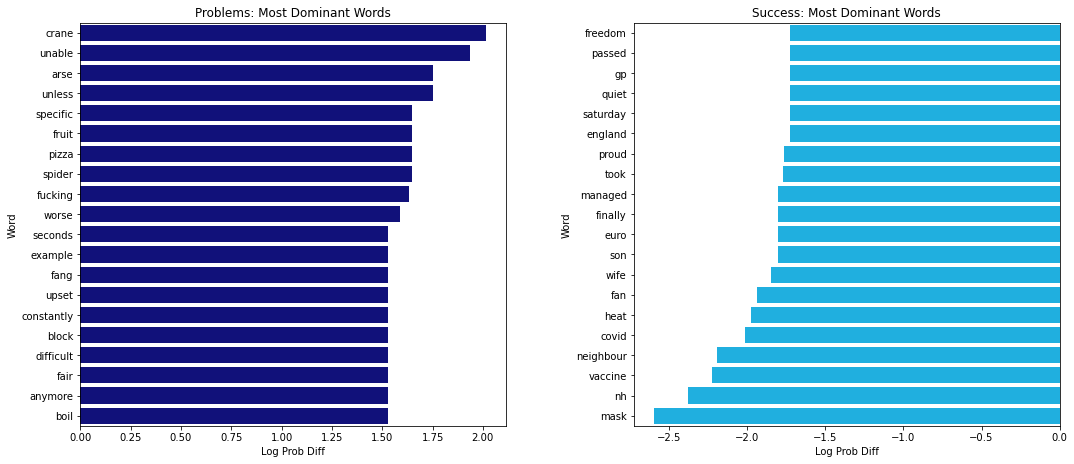

In [127]:
fig = plt.figure(figsize=(17,7))

ax1 = fig.add_subplot(1,2,1)
sns.barplot(data=log_diff_df.sort_values(ascending=False, by='Log Diff').head(20), y='Word', x='Log Diff', color='Darkblue', ax=ax1)
ax1.set_title('Problems: Most Dominant Words')
ax1.set_xlabel('Log Prob Diff')

ax2 = fig.add_subplot(1,2,2)
sns.barplot(data=log_diff_df.sort_values(ascending=False, by='Log Diff').tail(20), y='Word', x='Log Diff', color='deepskyblue', ax=ax2)
ax2.set_title('Success: Most Dominant Words')
ax2.set_xlabel('Log Prob Diff');

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.3)

### Misclassification Analysis

The model is not perfect and has gone wrong in some predictions. Before looking at the misclassified posts, I plotted the ROC curve which reflected an AUC score of 0.85 for my model. Coincidentally, we have quite similar false positive (72 posts) and false negatives (68 posts) - this is fairly ideal since we are aiming to be impartial to either false postives or negatives.

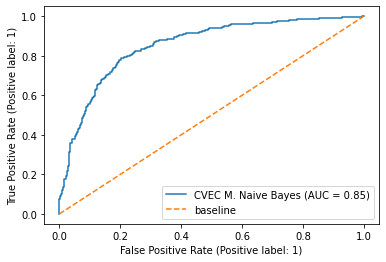

In [128]:
plot_roc_curve(gs_cvnb, X_test, y_test, name='CVEC M. Naive Bayes')
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

In [129]:
#ROC AUC score

roc_auc_score(y_test, gs_cvnb.predict_proba(X_test)[:,1])

0.8531324980005333

In [130]:
preds_cvnb = gs_cvnb.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds_cvnb).ravel()

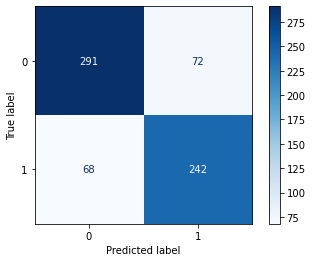

In [131]:
plot_confusion_matrix(gs_cvnb, X_test, y_test, cmap='Blues', values_format='d');

In the two tables below, I have reflected the 'worst' misclassified posts by sub-reddits. This definition of 'worst' is based on the model having a very high predict_proba for a particular class, and thus getting it very wrong when it misclassifies the post.

I have selected some of these posts to explain why the model could have misclassified them:

**Sarcasm**<br>
*'getting mildly excited buying a new vacuum cleaner head and realising you’ve reached peak middle age at 34.'* 

- This is wrongly classified as 'Success'.
- This is a classic example of self-depracating British humour in the form of sarcasm. Words associated with positivity ('excited', 'new', 'peak') probably led to this being misclassified as a 'Success'. 
- To improve, new models to perform sentence embedding (e.g. BERT) would potentially perform better. Instead of splitting up posts by words, and in the process losing their context, sentence embedding can might be useful in analysing the relationship between set of words/sentences in a more dynamic manner.

**Irony/Punchline at the end**<br>
while in a queue of car going the speed limit in a 30, i got overtaken by a numpty in a black bmw hatchback going around 50. i watched him dangerously weave through traffic while not progressing very far... he rev up, go nowhere and a plume of smoke come out of the back... i don't usually enjoy the mishap of others, but this really cheered up my day! i watched a boy racer in a bmw fry his engine

- This is wrongly classified as 'Problem'.
- The bulk of this post was to desribed the bad bahviour of a fellow motorist and plenty of negative descriptions were used ('dangerously', 'nowhere', 'crash', 'idiot'). However, the punchline of the joke comes in the end when the poster realised that the motorist had crashed and that 'really cheered up my day!'.
- Likewise, sentence embedding would potentially help improve the misclassificatioin of such examples.


***Coincidence***<br>
*'it get hoovered several time a week. is this some late-stage capitalism insanity, or am i just out of the loop? the sun is finally out after a wet saturday morning, perfect to enjoy some time in the garden, to the maddening soundtrack of next door hoovering their artificial grass.'*

- This is wrongly classified as 'Success'. There could be a few factors such as the positive words used in the posts ('perfect', 'enjoy').
- However, my suspicion is on the word 'Saturday' - this was one of the most 'different' word to explain 'British Success'. Upon further investigation, I found out the dataset contained 11 mentions of 'Saturday' in 'British Success' vs 4 mentions of in 'British Problems', and **all the mentions of 'Saturday' in the test set are for 'British Problems'**.
- This is an issue because out model would have likely to have trained on 'Saturday' in 'British Succes' posts only. When 'Saturday' appeared in 'British Problems' as per the test dataset - there would be a fair chance that this gets misclassified.
- A larger dataset would help avoid this problem as words will appear more frequently and have a high chance of being shuffled across both train and test sets.

In [132]:
problems_prob = [problems[1] for problems in gs_cvnb.predict_proba(X_test)]
success_prob = [success[0] for success in gs_cvnb.predict_proba(X_test)]
prediction = gs_cvnb.predict(X_test)

In [133]:
pred_prob = list(zip(success_prob, problems_prob, prediction, y_test, X_test))

In [134]:
pred_prob_df = pd.DataFrame(pred_prob, columns=['Success','Problems','Pred Value','True Value','Content'])

In [135]:
wrong_predictions = pred_prob_df[pred_prob_df['Pred Value'] != pred_prob_df['True Value']]

**Misclassified: Predict = British Problems but True = British Success**

In [136]:
wrong_predictions.sort_values(by='Problems', ascending=False).head(10)

,Success,Problems,Pred Value,True Value,Content
640,0.001755,0.998245,1,0,"while in a queue of car going the speed limit in a 30, i got overtaken by a numpty in a black bmw hatchback going around 50. i watched him dangerously weave through traffic while not progressing very far, and ended up sat behind him at a roundabout leading to a quiet industrial estate road. i watched him floor it out of sight, silently hoping that he crash into a tree rather than someone else on the road. a i got towards the end of the road, i see he's made a u turn and is about to do a return sprint. he rev up, go nowhere and a plume of smoke come out of the back. shortly after the hazard light come on and in my mirror i see the idiot getting out of his broken car. i don't usually enjoy the mishap of others, but this really cheered up my day! i watched a boy racer in a bmw fry his engine"
265,0.002541,0.997459,1,0,"a everyone else turn their nose up at anything vegan, and i am notoriously not fussy over what i'm consuming, he is happily sharing his stash with me. bonus: he doesn't care that what i get from the oops bay is rarely veggie, never mind vegan, and doesn't ask me to eat at a separate table from him. one of my colleague this week is a vegan and a sharer of snack"
235,0.003060,0.996940,1,0,nothing worse than sitting on a bus in 17c weather waiting for the driver to change. the bus drove straight past the depot without changing driver both ways.
102,0.005404,0.994596,1,0,love how #craftywank is a thing. i mean how doe one explain it to anyone other than a brit. it’s so ridiculous but so funny. faith in twitter restored
131,0.006707,0.993293,1,0,"danny, who review takeaway on yt. he's fantastic, he's a lovely bloke, he's exploding. no, i'm not related to him. get in now so you can say ""oh yeah, i've been watching him for ages"" to your mates."
356,0.006967,0.993033,1,0,"yeah, i probably sound like a bastard 'dobbing' someone in, but drive like a dick then take a shortcut down a bus route... you're a twat! submitting dash cam footage to the police, and the police taking action!"
589,0.012116,0.987884,1,0,always risky to insult someone's work when they're holding a bladed weapon while standing right behind you but this time it paid off found the courage to tell the hairdresser i didn't like my hair at the end of the haircut and she wa fine with it and fixed it
248,0.012383,0.987617,1,0,"i've put this a a success rather than a problem because i find their outlook so refreshing and it make me smile that they see people a good decade younger than them a ""old"". my 84 and 87 year old grandparent complaining about the grey hair/blue rinse brigade at the new working men's club they've joined"
569,0.016468,0.983532,1,0,"i just thought 'this is a good thing'. year ago there would have been zillion flying around. i live in a house backing on to fields, so i shouldn't be short of them. now i'm welcoming them, thinking there should be more. i certainly don't want to swat them any more. not getting bugged by the number of bug flying around my room with it window open."
7,0.021528,0.978472,1,0,using your jet wash to turn off next door loud music system in the garden. instant justice these idiot need to buy some wireless headphones.


**Misclassified: Predict = British Success but True = British Problems**

In [137]:
wrong_predictions.sort_values(by='Success', ascending=False).head(10)

,Success,Problems,Pred Value,True Value,Content
75,1.000000,1.414174e-10,0,1,"we bought our first house together last month. the wife hated the carpet and wall in the main bedroom but our work holiday diary were full. so for the pas two weeks, i've ripped up the old carpet and the laminate flooring below it, got an electrician to put in three double plug socket with usb point a there wa just a single plug socket in the whole room, repainted every wall white with four coat (they were all pink before). and reprinted the shirting-boards. all mainly on my hour lunch break while i'm working from home. we also needed a plasticer to fill in the hole left from the new plug sockets. we couldn't find a qualified plasticer so the wife got some training at work from a plasticer (she work on a building site.) and she did at the plasticing a couple of weekend ago. we were just replacing the curtain pole when the wife spotted a leak. she wa just out the shower. it look like there is a leak in the en-suite shower room. i did get the week off this week so i can decorate the dinner room, hallway and living room with the carpet fixer coming monday morning 9am to fix the new carpet in the bedroom. we, just, managed to get hold of the carpet fitter to postpone it a few week and the insurance company. both closed at 4pm on a sunday. we discovered the leak at 345pm. now a plumber coming instead of carpet fitter and i'm going to have to re-decorate half of that bedroom again once it's all be sorted. better go to b&amp;q for more paint. spending lunchtime for the past two week (and two weekend in a row) decorating the main bedroom. finishing it on the sunday afternoon before the carpet fitter come monday... just found a leak!!!"
428,0.999975,2.498114e-05,0,1,"it get hoovered several time a week. is this some late-stage capitalism insanity, or am i just out of the loop? the sun is finally out after a wet saturday morning, perfect to enjoy some time in the garden, to the maddening soundtrack of next door hoovering their artificial grass."
360,0.999623,3.765296e-04,0,1,"for my sims i watch a certain breakfast to show, and it seems like near enough every week there is a “these award ceremony went on last night, let’s look at who won, what they won, what they won it for, what they wore, the party they went to, what they said, etc” &amp;#x200b; i really don’t care, i will watch your tv programmes, but couldn’t give a crap about the award you then win, or who should have won instead not caring one bit about “award shows”"
629,0.998978,1.021585e-03,0,1,"there wa one small piece of sausage in the whole slice! one! would not have again saw a post yesterday about vegan greggs product with great reviews, thought i'd try the vegan sausage cheesz and bean slice - wa massively disappointed!"
605,0.995229,4.770634e-03,0,1,"the guy picked it up with a bag, but the smell still reached me at the other end of the carriage. a dog just took a shit on the floor of the overground. happy monday morning..!"
457,0.995215,4.785398e-03,0,1,"unfortunately waterstones ship their book in cardboard so i now have a signed first edition of a book no longer available to buy with run ink and damaged page getting home after a week to find that, instead of taking an undelivered item to the sorting office, the postman decided to drop the clearly labelled waterstones package over my back fence for it to sit in the rain in the flower bed."
660,0.993099,6.901117e-03,0,1,"last month they opened the door, left the parcel and walked away after ringing the doorbell to get my attention. today he tried the front door to establish whether it wa locked or not, when it wa unlocked, he closed it, rang the bell and passed the parcel to me! i didn’t say anything a i can’t deal with confrontation so i have been onto the the live chat section to complain. having amazon driver thinking that it is ok to open my front door to leave package rather than ring the bell like they are supposed to. this ha now happen

# Conclusion

**Summmary**<br>
In conclusion, the best model for me is the Lemmatization and CountVectorizer x Multinomial Naive Bayes. It gave good accuracy score of **79%**, which is higher than the bestline of 46%. From a misclassification perspective, it has the best F1 score and a good balance of false positives and negatives. 

With these in mind, I can conclude that the model does fairly well in classifying the two sub-reddits and there are considerable differences between the two sub-reddits. To answer the problem statement, I could conclude with a fair amount of confidence that setting up SingaporeanSuccess and SingaporeanProblem sub-reddits at the same time would not cannabalise viewers based on the topics itself. 

**Limitations**<br>
However, as pointed out, there are limitations with my model in terms of the size of that data. In total, there were only 2.6k posts in this dataset, and with most of them coming from the recent month. It will be better if I have access to more data of a longer time period so as to widen the scope of the words for the model to train on (for example, our model is trained on words popular in the recent time period - e.g. Euros, crane flies)

Similarly, sarcasm/irony are probably better analysed in the context of the sentence itself. As my misclassification analysis have pointed out, word vectorization have a good chance of missing the nuances used in ironic language. Sentence embedding with newer models such as BERT could potentially be helpful in analysing humour.

Bring this back to our problem statement, I am also not 100% confident that this will also work as well for Singaporean humour, which by itself is also a very dynamic language with its own linguistic structures. For example, will the model be able to predict the nuances between 'can *lah*', 'can *leh*', can *lor*'? This will be something interesting to be explored further.

Good luck!
<img src="https://blog.spjain.org/wp-content/muploads/2011/06/LAh-2.jpg" style="float: center; margin: 20px; height: 400px">